In [4]:
__author__ = "Divyam Balani"
__email__ = "divyambalani@gmail.com"
__website__ = "https://github.com/divyamb"

In [5]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA

#model building imports
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

#Pipeline and preprocessing imports
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

#evaluation metrics imports
from sklearn.metrics import mean_squared_error as mse

In [6]:
#Helper Functions
def load_file(file):
    return pd.read_csv(file)

def combine_data(df_1, df_2, key):
    return pd.merge(df_1, df_2, on = key)

def clean_data_basic(raw_data,target):
    clean_data = raw_data.drop_duplicates(subset='jobId')
    clean_data = clean_data[clean_data[target]>0]
    return clean_data

def get_target(df, target):
    return df[target]

def get_numerical_features(df):
    return df.select_dtypes(exclude='object').apply(pd.to_numeric)

def get_categorical_features(df):
    return df.select_dtypes(exclude=['int64','float64'])

def encoding(df, cleanup_dict):
    cat_df = get_categorical_features(df)
    non_dummy_cols = ['jobId','jobType','degree']
    dummy_cols = list(set(cat_df.columns) - set(non_dummy_cols))
    ordinal_encoded_features = cat_df.replace(cleanup_dict)
    dummies = pd.get_dummies(ordinal_encoded_features, columns = dummy_cols)
    return dummies 

def create_final_df(df, cleanup_dict):
    num_df = get_numerical_features(df)
    final_cat_df = encoding(df, cleanup_dict).drop(['jobId'], axis=1)
    return pd.concat([final_cat_df, num_df], axis=1)

def feature_engineered_model(model, train_df, target_df, num_processes, mean_mse):
    neg_mse = cross_val_score(model, train_df, target_df, cv=5, n_jobs=num_processes, scoring='neg_mean_squared_error')
    mean_mse[model] = -1.0*(sum(neg_mse)/5)

def print_summary(model, mean_mse, cv_std):
    print('\nModel:\n', model)
    print('Average MSE:\n', mean_mse[model])

def save_results(model, mean_mse, predictions, feature_importances):
    with open('model.txt', 'w') as file:
        file.write(str(model))
    feature_importances.to_csv('feature_importances.csv') 
    np.savetxt('predictions_salaries.csv', predictions, delimiter=',')


In [7]:
## Loading Files and paths
test_features_path = '../data/external/test_features.csv'
train_features_path = '../data/external/train_features.csv'
train_salaries_path = '../data/external/train_salaries.csv'

feature_data = load_file(train_features_path)
test_data = load_file(test_features_path)
salaries_data = load_file(train_salaries_path)

In [16]:
#create variables
cleanup_cat = { 'jobType': 
               {'JANITOR': 1, 'JUNIOR': 2,'SENIOR': 3, 'MANAGER': 4,'VICE_PRESIDENT': 5,'CTO': 6,'CFO': 7,'CEO': 8},
               'degree':
               {'NONE': 1, 'HIGH_SCHOOL': 2,'BACHELORS': 3, 'MASTERS': 4,'DOCTORAL': 5}}

train_df = combine_data(feature_data, salaries_data, 'jobId')
train_df = clean_data_basic(train_df,'salary')
target = get_target(train_df, 'salary')

final_train = create_final_df(train_df, cleanup_cat)
final_test = create_final_df(test_data, cleanup_cat)
final_train = final_train.drop(['salary'],axis=1)

In [17]:
final_train.head()

,jobType,degree,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB,major_BIOLOGY,...,companyId_COMP59,companyId_COMP6,companyId_COMP60,companyId_COMP61,companyId_COMP62,companyId_COMP7,companyId_COMP8,companyId_COMP9,yearsExperience,milesFromMetropolis
0,7,4,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,10,83
1,8,2,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,3,73
2,5,5,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,10,38
3,4,5,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,17
4,5,3,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,8,16


In [18]:
models = []
mean_mse = {}
cv_std = {}

#num of processes it should run in parallel
num_processes = 2

#model params
verbose_level = 0

#create models -- hyperparameter tuning done by hand
lr = LinearRegression()
lr_std_pca = make_pipeline(StandardScaler(), PCA(), LinearRegression())
rf = RandomForestRegressor(n_estimators=150, n_jobs=num_processes, max_depth=30, min_samples_split=60, \
                           max_features=30, verbose=verbose_level)
gbm = GradientBoostingRegressor(n_estimators=150, max_depth=6, loss='ls', verbose=verbose_level)
                      
models.extend([lr, lr_std_pca, rf, gbm])

#parallel cross-validate models, using MSE as evaluation metric, and print summaries
print("Begin CV")
for model in models:
    feature_engineered_model(model, final_train, target, num_processes, mean_mse)
    print_summary(model, mean_mse, cv_std)

Begin CV

Model:
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Average MSE:
 394.4651234637697

Model:
 Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)
Average MSE:
 394.4651454925367

Model:
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features=30, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=60,
                      

In [19]:
#choose model with lowest mse
model = min(mean_mse, key=mean_mse.get)
print('\nPredictions calculated using model with lowest MSE:')
print(model)

#train model on entire dataset
model.fit(final_train, target)

#create predictions based on test data
predictions = model.predict(final_test)


Predictions calculated using model with lowest MSE:
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=6,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [20]:
#store feature importances
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
else:
    #linear models don't have feature_importances_
    importances = [0]*len(final_train.columns)
    
feature_importances = pd.DataFrame({'feature':final_train.columns, 'importance':importances})
feature_importances.sort_values(by='importance', ascending=False, inplace=True)
#set index to 'feature'
feature_importances.set_index('feature', inplace=True, drop=True)

#save results
save_results(model, mean_mse[model], predictions, feature_importances)

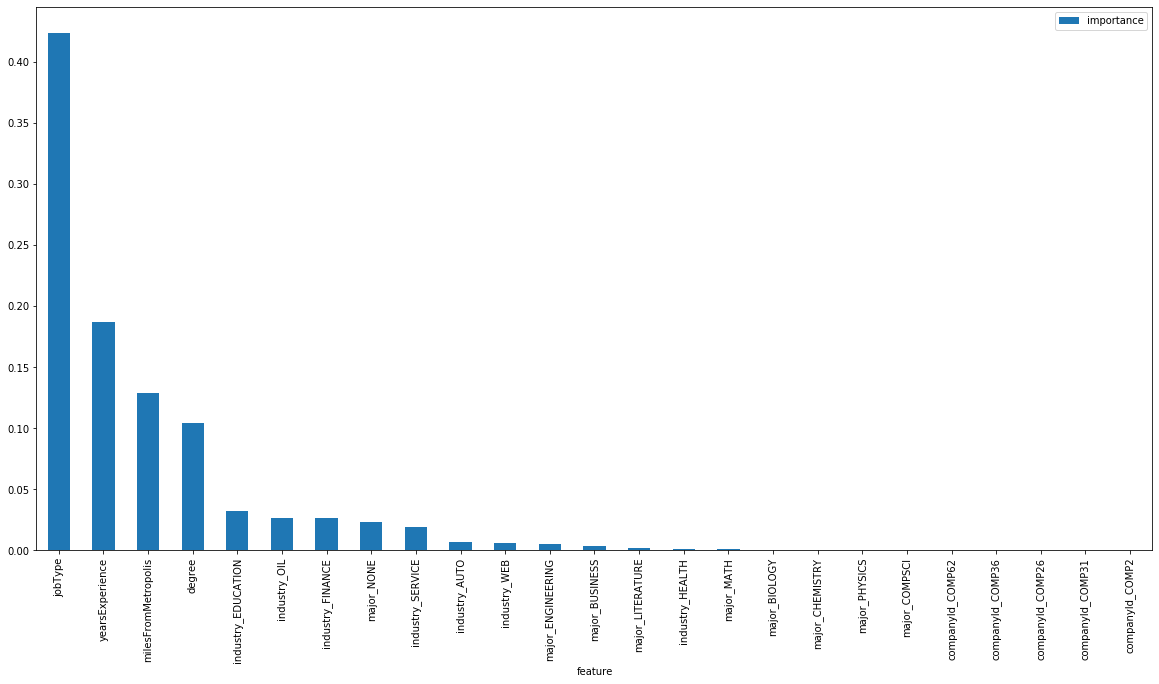

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
feature_importances[0:25].plot.bar(figsize=(20,10))
plt.show()